<center><h1>Visual Question Answering (VQA)</h1></center>

In [1]:
#installing packages (since i'm using google colab,i'm installing from notebook itself)

#%%capture
#!pip3 install --upgrade tensorflow-gpu
#!pip install tensorflow --upgrade

In [2]:
#importing packages
import warnings
warnings.filterwarnings("ignore")
import json
import pickle
import os
import pandas as pd
import random as rn
import numpy as np
import tensorflow as tf
from google.colab import drive
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.regularizers import l1,l2
from tqdm import tqdm
import heapq
from sklearn.utils import shuffle
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.model_selection import train_test_split

Populating the interactive namespace from numpy and matplotlib


<h1>Mounting the Drive </h1>

In [3]:
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


<h1>Variables</h1>

In [5]:
currentDirectory = "/content/drive/MyDrive/DOP 3-2"
os.chdir(currentDirectory)
currentDirectory = ""

In [6]:

dataDirectory = currentDirectory + "FloodNet Challenge @ EARTHVISION 2021 - Track 2/"
imageDirectory = dataDirectory + "Images/"

imagefeaturesDirectory = currentDirectory + "ImageFeatures_448/"
imageNumpyDirectory = currentDirectory + "ImageNumpy/"
modelsDirectory = currentDirectory + "CoAttention/"
img_width = 448
img_height = 448

BATCH_SIZE = 16 #HYPERPARAMETER
BUFFER_SIZE = 300

In [7]:
questions_train = dataDirectory + "Questions/Training Question.json"

# questions_valid = dataDirectory + "Questions/Valid Question.json"

# questions_test = dataDirectory + "Questions/Test_Question.json"


# #len(os.listdir(imageNumpyDirectory))
# data = pd.read_csv(dataDirectory + 'data.csv')
# X_train, X_val = train_test_split(data, test_size=0.2, random_state=42)

In [8]:
%pwd

'/content/drive/.shortcut-targets-by-id/1xgrvgd3-UO5MzK2tcqtk5V7Xk9APCY6t/DOP 3-2'

In [9]:
f = open(os.path.join(os.getcwd(), questions_train))
qtrain_data = json.load(f)

print(json.dumps(qtrain_data['1'], indent = 1))

{
 "Image_ID": "10166.JPG",
 "Question": "What is the overall condition of the given image?",
 "Ground_Truth": "flooded",
 "Question_Type": "Condition_Recognition"
}


In [10]:
X = pd.read_json('/content/drive/MyDrive/DOP 3-2/FloodNet Challenge @ EARTHVISION 2021 - Track 2/Questions/Training Question.json')
X = X.transpose()



# X_train = pd.read_json('/content/drive/MyDrive/DOP 3-2/FloodNet Challenge @ EARTHVISION 2021 - Track 2/Questions/Training Question.json')

# X_val   = pd.read_json('/content/drive/MyDrive/DOP 3-2/FloodNet Challenge @ EARTHVISION 2021 - Track 2/Questions/Valid Question.json')

# X_test  = pd.read_json('/content/drive/MyDrive/DOP 3-2/FloodNet Challenge @ EARTHVISION 2021 - Track 2/Questions/Test_Question.json')

# X_train = X_train.transpose()
# X_val = X_val.transpose()
# X_test = X_test.transpose()

In [11]:
def train_validate_test_split(df, train_percent=.7, validate_percent=.1, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test


X_train, X_val, X_test = train_validate_test_split(X, seed=[42,1415])

In [12]:
X_train.head()

,Image_ID,Question,Ground_Truth,Question_Type
2215,7430.JPG,What is the overall condition of the given image?,flooded,Condition_Recognition
4081,9028.JPG,What is the condition of the road in this image?,non flooded,Condition_Recognition
4071,9023.JPG,What is the condition of road?,non flooded,Condition_Recognition
1545,7102.JPG,What is the condition of the road in this image?,non flooded,Condition_Recognition
2767,7731.JPG,What is the overall condition of the given image?,non flooded,Condition_Recognition


In [13]:
X_train.describe()

,Image_ID,Question,Ground_Truth,Question_Type
count,3157,3157,3157,3157
unique,1289,15,41,4
top,7311.JPG,What is the overall condition of the given image?,non flooded,Condition_Recognition
freq,6,998,1351,1609


In [14]:
X_val.describe()

,Image_ID,Question,Ground_Truth,Question_Type
count,451,451,451,451
unique,394,15,27,4
top,6707.JPG,What is the overall condition of the given image?,non flooded,Condition_Recognition
freq,3,139,194,224


In [15]:
print("No of training points are:- " + str(len(X_train)))
print("No of validation points are:- " + str(len(X_val)))
print("No of testing points are:- " + str(len(X_test)))

No of training points are:- 3157
No of validation points are:- 451
No of testing points are:- 903


# <h1>1. Creating Answer Vectors </h1>

Simple Counting {1,2,3,4...}

Complex Counting {1,2,3,4...}

Condition of Road
(sub-category of Condition Recognition)
 
Flooded , Non-Flooded, Flooded & Non-Flooded

Condition of Entire Image
(sub-category of Condition Recognition) Flooded , Non-Flooded

Yes/No-Type Question
(sub-category of Condition Recognition) Yes, No

In [16]:
contractions = { 
"ain't": "am not","aren't": "are not","can't": "cannot","can't've": "cannot have","'cause": "because","could've": "could have","couldn't": "could not",
"couldn't've": "could not have","didn't": "did not","doesn't": "does not","don't": "do not","hadn't": "had not","hadn't've": "had not have",
"hasn't": "has not","haven't": "have not","he'd": "he would","he'd've": "he would have","he'll": "he will","he's": "he is","how'd": "how did",
"how'll": "how will","how's": "how is","i'd": "i would","i'll": "i will","i'm": "i am","i've": "i have","isn't": "is not","it'd": "it would",
"it'll": "it will","it's": "it is","let's": "let us","ma'am": "madam","mayn't": "may not","might've": "might have","mightn't": "might not",
"must've": "must have","mustn't": "must not","needn't": "need not","oughtn't": "ought not","shan't": "shall not","sha'n't": "shall not","she'd": "she would",
"she'll": "she will","she's": "she is","should've": "should have","shouldn't": "should not","that'd": "that would","that's": "that is","there'd": "there had",
"there's": "there is","they'd": "they would","they'll": "they will","they're": "they are","they've": "they have","wasn't": "was not","we'd": "we would",
"we'll": "we will","we're": "we are","we've": "we have","weren't": "were not","what'll": "what will","what're": "what are","what's": "what is",
"what've": "what have","where'd": "where did","where's": "where is","who'll": "who will","who's": "who is","won't": "will not","wouldn't": "would not",
"you'd": "you would","you'll": "you will","you're": "you are"
}

def preprocess_english(text):
    '''Given a text this function removes the punctuations and returns the remaining text string'''
    new_text = ""
    text = text.lower()
    i = 0
    for word in text.split():
      if i==0:
        new_text = contractions.get(word,word)
      else:
        new_text = new_text + " " + contractions.get(word,word)
      i += 1
    return new_text.replace("'s", '')

In [17]:
#NO need 
# X_train['Ground_Truth'] = X_train['Ground_Truth'].apply(lambda x: preprocess_english(x))
# X_val['Ground_Truth'] = X_val['Ground_Truth'].apply(lambda x: preprocess_english(x))
# X_test['Ground_Truth'] = X_test['Ground_Truth'].apply(lambda x: preprocess_english(x))

In [18]:
all_classes = X_train['Ground_Truth'].values
class_frequency = {}

for _cls in all_classes:
    if(class_frequency.get(_cls,-1)>0):
        class_frequency[_cls] += 1
    else:
        class_frequency[_cls] = 1

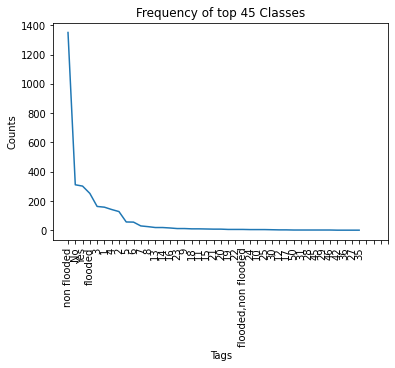

In [19]:
sort_class_frequency = sorted(list(class_frequency.items()),key = lambda x: x[1],reverse=True)   

plt.plot([x[1] for x in sort_class_frequency[:45]])
i=np.arange(45)
plt.title("Frequency of top 45 Classes")
plt.xlabel("Tags")
plt.ylabel("Counts")
plt.xticks(i,[x[0] for x in sort_class_frequency[:45]])
plt.xticks(rotation=90)
plt.show()

No of classes

In [20]:
print(len(sort_class_frequency))

41


5 most frequent Classes covers 75.36% points
10 most frequent Classes covers 92.49% points
15 most frequent Classes covers 95.95% points
20 most frequent Classes covers 97.62% points
25 most frequent Classes covers 98.70% points
30 most frequent Classes covers 99.40% points
35 most frequent Classes covers 99.75% points
40 most frequent Classes covers 99.97% points
45 most frequent Classes covers 100.00% points


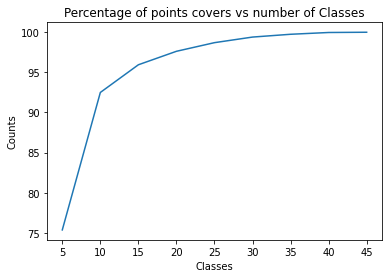

In [21]:
def getPercentageOfDataCoversGivenNumClasses(n_class, class_frequency, df):
    n_common_class = heapq.nlargest(n_class, class_frequency, key=class_frequency.get)
    count = 0
    for _class in df['Ground_Truth'].values:
        if(_class in n_common_class):
            count += 1

    return (count/len(df))*100
    
n_classes = [5,10,15,20,25,30,35,40,45]
percentage_cover = []
for i in n_classes:
    temp = getPercentageOfDataCoversGivenNumClasses(i,class_frequency,X_train)
    percentage_cover.append(temp)
    print("{} most frequent Classes covers {:.2f}% points".format(i,temp))


plt.plot(percentage_cover)
i=np.arange(len(percentage_cover))
plt.title("Percentage of points covers vs number of Classes")
plt.xlabel("Classes")
plt.ylabel("Counts")
plt.xticks(i,n_classes)
plt.show()

In [22]:
num = []
for x in sort_class_frequency[:45]:
  try:
    if int(x[0]) > 0:
      num.append(int(x[0]))
  except:
    pass    
  print(x)

num = sorted(num)
print(num)  

('non flooded', 1351)
('No', 311)
('Yes', 302)
('flooded', 252)
(3, 163)
(1, 158)
(4, 142)
(2, 128)
(5, 57)
(6, 56)
(7, 30)
(8, 25)
(13, 19)
(14, 19)
(16, 16)
(23, 12)
(9, 12)
(18, 10)
(11, 10)
(15, 9)
(21, 8)
(20, 8)
(19, 6)
(22, 6)
('flooded,non flooded', 6)
(24, 5)
(10, 5)
(25, 5)
(30, 4)
(12, 3)
(17, 3)
(50, 2)
(31, 2)
(28, 2)
(45, 2)
(29, 2)
(46, 2)
(42, 1)
(36, 1)
(27, 1)
(35, 1)
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 35, 36, 42, 45, 46, 50]


In [23]:
# common_tags = heapq.nlargest(41, class_frequency, key = class_frequency.get)
# X_train['Ground_Truth'] =  X_train['Ground_Truth'].apply(lambda x: x if x in common_tags else '')

#removing question which has empty tags weren't there
# X_train = X_train[X_train['Ground_Truth'].apply(lambda x: len(x)>0)]

In [24]:
X_train['Ground_Truth'] = X_train['Ground_Truth'].astype(str)
X_test['Ground_Truth'] = X_test['Ground_Truth'].astype(str)
X_val['Ground_Truth'] = X_val['Ground_Truth'].astype(str)

label_encoder = LabelBinarizer()
answer_vector_train = label_encoder.fit_transform(X_train['Ground_Truth'].apply(lambda x: x).values)
answer_vector_val = label_encoder.transform(X_val['Ground_Truth'].apply(lambda x: x).values)
answer_vector_test = label_encoder.transform(X_test['Ground_Truth'].apply(lambda x: x).values)

ans_vocab = {l: i for i, l in enumerate(label_encoder.classes_)}
print(ans_vocab)
print("Number of clasess: ", len(ans_vocab))
print("Shape of Answer Vectors in Train Data: ", answer_vector_train.shape)
print("Shape of Answer Vectors in Validation Data: ", answer_vector_val.shape)
print("Shape of Answer Vectors in Test Data: ", answer_vector_test.shape)

{'1': 0, '10': 1, '11': 2, '12': 3, '13': 4, '14': 5, '15': 6, '16': 7, '17': 8, '18': 9, '19': 10, '2': 11, '20': 12, '21': 13, '22': 14, '23': 15, '24': 16, '25': 17, '27': 18, '28': 19, '29': 20, '3': 21, '30': 22, '31': 23, '35': 24, '36': 25, '4': 26, '42': 27, '45': 28, '46': 29, '5': 30, '50': 31, '6': 32, '7': 33, '8': 34, '9': 35, 'No': 36, 'Yes': 37, 'flooded': 38, 'flooded,non flooded': 39, 'non flooded': 40}
Number of clasess:  41
Shape of Answer Vectors in Train Data:  (3157, 41)
Shape of Answer Vectors in Validation Data:  (451, 41)
Shape of Answer Vectors in Test Data:  (903, 41)


# <h1> 2. Creating Image Features using VGG19 </h1>

In [25]:
image_paths_train = X_train['Image_ID'].apply(lambda x:  imageDirectory + 'Train_Image/' + x).values
image_paths_val = X_val['Image_ID'].apply(lambda x:  imageDirectory + 'Train_Image/' + x).values # important bervcause now train set is only divided 
image_paths_test = X_test['Image_ID'].apply(lambda x:  imageDirectory + 'Train_Image/' + x).values

In [26]:
print(image_paths_test)

['FloodNet Challenge @ EARTHVISION 2021 - Track 2/Images/Train_Image/8317.JPG'
 'FloodNet Challenge @ EARTHVISION 2021 - Track 2/Images/Train_Image/7653.JPG'
 'FloodNet Challenge @ EARTHVISION 2021 - Track 2/Images/Train_Image/6707.JPG'
 'FloodNet Challenge @ EARTHVISION 2021 - Track 2/Images/Train_Image/6388.JPG'
 'FloodNet Challenge @ EARTHVISION 2021 - Track 2/Images/Train_Image/8264.JPG'
 'FloodNet Challenge @ EARTHVISION 2021 - Track 2/Images/Train_Image/6531.JPG'
 'FloodNet Challenge @ EARTHVISION 2021 - Track 2/Images/Train_Image/7820.JPG'
 'FloodNet Challenge @ EARTHVISION 2021 - Track 2/Images/Train_Image/6978.JPG'
 'FloodNet Challenge @ EARTHVISION 2021 - Track 2/Images/Train_Image/9063.JPG'
 'FloodNet Challenge @ EARTHVISION 2021 - Track 2/Images/Train_Image/7655.JPG'
 'FloodNet Challenge @ EARTHVISION 2021 - Track 2/Images/Train_Image/10834.JPG'
 'FloodNet Challenge @ EARTHVISION 2021 - Track 2/Images/Train_Image/8822.JPG'
 'FloodNet Challenge @ EARTHVISION 2021 - Track 2/I

In [27]:
combined_img_path = np.unique(np.hstack((image_paths_train, image_paths_val, image_paths_test)))
# X_train['Image_ID'].append(X_val['Image_ID'], ignore_index = True).append(X_test['Image_ID'], ignore_index = True)
print(len(combined_img_path))

1448


In [28]:
print(combined_img_path)

['FloodNet Challenge @ EARTHVISION 2021 - Track 2/Images/Train_Image/10165.JPG'
 'FloodNet Challenge @ EARTHVISION 2021 - Track 2/Images/Train_Image/10166.JPG'
 'FloodNet Challenge @ EARTHVISION 2021 - Track 2/Images/Train_Image/10168.JPG'
 ...
 'FloodNet Challenge @ EARTHVISION 2021 - Track 2/Images/Train_Image/9897.JPG'
 'FloodNet Challenge @ EARTHVISION 2021 - Track 2/Images/Train_Image/9898.JPG'
 'FloodNet Challenge @ EARTHVISION 2021 - Track 2/Images/Train_Image/9925.JPG']


In [57]:
!pip install vit-keras

     |████████████████████████████████| 686kB 7.7MB/s 


In [68]:
from vit_keras import vit, utils
# def VGG_Top():
#     model = tf.keras.applications.VGG19(include_top=False,weights='imagenet',input_shape = (img_width, img_height,3))
#     input_layer = model.input
#     hidden_layer = model.layers[-1].output 
#     model = tf.keras.Model(input_layer, hidden_layer)
#     return model

def VGG_Top():
    image_size = 448
    model = vit.vit_b16(image_size=image_size,activation='sigmoid',pretrained=True,include_top=False,pretrained_top=False)
    return model

def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (img_width, img_height))
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return img, image_path


Run once only 

In [69]:

def generateImageFeatures(images, dir, numpydir):
    model = VGG_Top()
    all_image_dict = {}
    img_ds = tf.data.Dataset.from_tensor_slices(images)
    img_ds = img_ds.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

    for batch_img, batch_path in img_ds:
        batch_img_features = model(batch_img)
        # print(batch_img_features.shape)

        for img_features, path in zip(batch_img_features, batch_path):
            image_path = path.numpy().decode("utf-8")
            # image_path = image_path.replace(dir,numpydir).replace('.jpg',"")
            # np.save(image_path, img_features.numpy())
            all_image_dict[image_path] = img_features.numpy()

    with open(dir + 'all_image_dict.pickle', 'wb') as handle:
        pickle.dump(all_image_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

    return

# all_image_path = combined_data['Image_ID'].apply(lambda x:  imageDirectory + 'COCO_train2014_' + '%012d.jpg' % (x)).unique()
generateImageFeatures(combined_img_path, imagefeaturesDirectory, imageNumpyDirectory)

(None, 14, 14, 512)


KeyboardInterrupt: ignored

In [31]:
# image_paths_train = X_train['Image_ID'].apply(lambda x:  imageDirectory + 'Train_Image/' + x).values
# image_paths_val = X_val['Image_ID'].apply(lambda x:  imageDirectory + 'Valid_Image/' + x).values
# image_paths_test = X_test['Image_ID'].apply(lambda x:  imageDirectory + 'Test_Image/' + x).values

with open(imagefeaturesDirectory + 'all_image_dict.pickle', 'rb') as handle:
    all_image_dict = pickle.load(handle)

# with open(dataDirectory + 'all_image_dict_new.pickle', 'rb') as handle:
#     all_image_dict_new = pickle.load(handle)

# all_image_dict.update(all_image_dict_new)
# del all_image_dict_new

# <h1>3. Creating Question Vectors </h1>

In [32]:
def preprocess_english(text):
    '''Given a text this function removes the punctuations and returns the remaining text string'''
    new_text = "<start>"
    text = text.lower()
    for word in text.split():
      new_text = new_text + " " + contractions.get(word,word)
    new_text = new_text + " <end>"
    return new_text.replace("'s", '')

In [33]:
X_train['Question'] = X_train['Question'].apply(lambda x: preprocess_english(x))
X_val['Question'] = X_val['Question'].apply(lambda x: preprocess_english(x))
X_test['Question'] = X_test['Question'].apply(lambda x: preprocess_english(x))

In [34]:
#tokenization
tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token = "<unk>", filters = '!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(X_train['Question'].values)
train_question_seqs = tokenizer.texts_to_sequences(X_train['Question'].values)
val_question_seqs = tokenizer.texts_to_sequences(X_val['Question'].values)
test_question_seqs = tokenizer.texts_to_sequences(X_test['Question'].values)

print("Number of words in tokenizer:", len(tokenizer.word_index))
ques_vocab = tokenizer.word_index

#Padding
#tokenizer.word_index['<pad>'] = 0
#tokenizer.index_word[0] = '<pad>'
question_vector_train = tf.keras.preprocessing.sequence.pad_sequences(train_question_seqs, padding='post')
question_vector_val = tf.keras.preprocessing.sequence.pad_sequences(val_question_seqs,padding='post',maxlen=question_vector_train.shape[1])
question_vector_test = tf.keras.preprocessing.sequence.pad_sequences(test_question_seqs,padding='post',maxlen=question_vector_train.shape[1])

print("Shape of Question Vectors in Train Data: ", question_vector_train.shape)
print("Shape of Question Vectors in Validation Data: ", question_vector_val.shape)
print("Shape of Question Vectors in Test Data: ", question_vector_test.shape)

del train_question_seqs,val_question_seqs,test_question_seqs
del X_train

Number of words in tokenizer: 24
Shape of Question Vectors in Train Data:  (3157, 13)
Shape of Question Vectors in Validation Data:  (451, 13)
Shape of Question Vectors in Test Data:  (903, 13)


# <h1>4. Creating Datasets </h1>

In [35]:
def get_imageTensor(img, ques):
    #img_tensor = np.load(img.decode('utf-8').replace(imageDirectory,imageNumpyDirectory).replace(".jpg","") + '.npy')
    img_tensor = all_image_dict[img.decode('utf-8')]
    #img_tensor = img_tensor.T
    img_tensor = np.reshape(img_tensor,(-1,img_tensor.shape[-1]))
    return img_tensor, ques

In [36]:
def createDataset(image_paths,question_vector,answer_vector):
    dataset_input = tf.data.Dataset.from_tensor_slices((image_paths, question_vector.astype(np.float32)))
    dataset_output = tf.data.Dataset.from_tensor_slices((answer_vector))
    # using map to load the numpy files in parallel
    dataset_input = dataset_input.map(lambda img, ques : tf.numpy_function(get_imageTensor, [img, ques], [tf.float32, tf.float32]),
                                      num_parallel_calls = tf.data.experimental.AUTOTUNE)

    # shuffling and batching
    #dataset_input = dataset_input.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    dataset_input = dataset_input.batch(BATCH_SIZE)
    dataset_output = dataset_output.batch(BATCH_SIZE)#.repeat()
    
    dataset = tf.data.Dataset.zip((dataset_input, dataset_output))
    dataset = dataset.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)

    return dataset    

In [37]:
dataset_train = createDataset(image_paths_train, question_vector_train, answer_vector_train)
dataset_val = createDataset(image_paths_val, question_vector_val, answer_vector_val)
dataset_test = createDataset(image_paths_test, question_vector_test, answer_vector_test)

Our val and test set doesn't have labels 

In [38]:
# def is_val(x, _):
#     return x % 5 == 0


# def is_train(x, y):
#     return not is_val(x, y)


# recover = lambda x, y: y

# # Split the dataset for training.
# dataset_train_val = dataset_train.enumerate() \
#     .filter(is_val) \
#     .map(recover)

# # Split the dataset for testing/validation.
# dataset_train_train = dataset_train.enumerate() \
#     .filter(is_train) \
#     .map(recover)


# <h1>5. Parallel Coattention Model</h1>
### <h3>Hierarchical Question-Image Co-Attention for Visual Question Answering - https://arxiv.org/pdf/1606.00061v5.pdf</h3>

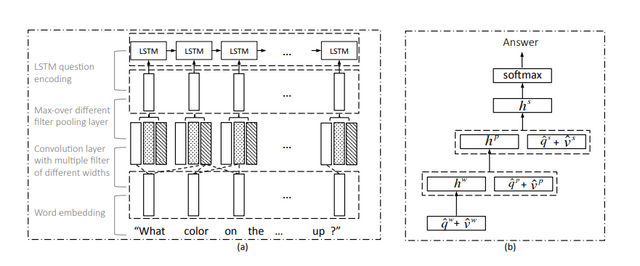

In [39]:
##fixing numpy RS
np.random.seed(42)

##fixing tensorflow RS
tf.random.set_seed(32)

##fixing python RS
rn.seed(12)

In [40]:
print(question_vector_train.shape[1])

13


In [41]:
class CoattentionModel(tf.keras.layers.Layer):
    def __init__(self):#, num_embeddings, num_classes, embed_dim=512, k=30
        super().__init__()
        self.num_classes = len(ans_vocab)
        self.hidden_size = 512
        self.dropout = 0.3
        self.num_embeddings = len(ques_vocab)+1

        self.image_dense = tf.keras.layers.Dense(self.hidden_size, kernel_initializer = tf.keras.initializers.glorot_normal(seed=15)) 
        self.image_corr = tf.keras.layers.Dense(self.hidden_size, kernel_initializer = tf.keras.initializers.glorot_normal(seed=29))

        self.image_atten_dense = tf.keras.layers.Dense(self.hidden_size, kernel_initializer = tf.keras.initializers.glorot_uniform(seed=17)) 
        self.question_atten_dens = tf.keras.layers.Dense(self.hidden_size, kernel_initializer = tf.keras.initializers.glorot_uniform(seed=28))
        self.question_atten_dropout = tf.keras.layers.Dropout(self.dropout)
        self.image_atten_dropout = tf.keras.layers.Dropout(self.dropout)

        self.ques_atten = tf.keras.layers.Dense(1, kernel_initializer = tf.keras.initializers.glorot_uniform(seed=21))

        self.img_atten = tf.keras.layers.Dense(1, kernel_initializer = tf.keras.initializers.glorot_uniform(seed=33))

        self.embed = tf.keras.layers.Embedding(self.num_embeddings, self.hidden_size,
                                               embeddings_initializer = tf.keras.initializers.RandomNormal(mean=0, stddev=1, seed=23))
        
        self.unigram_conv = tf.keras.layers.Conv1D(filters = self.hidden_size, kernel_size = 1, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed=41))
        self.bigram_conv  = tf.keras.layers.Conv1D(filters = self.hidden_size, kernel_size = 2, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed=58), dilation_rate = 2)
        self.trigram_conv = tf.keras.layers.Conv1D(filters = self.hidden_size, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed=89), dilation_rate = 2)
        self.max_pool = tf.keras.layers.MaxPool2D((3,1))
        self.phrase_dropout = tf.keras.layers.Dropout(self.dropout)
        
        self.lstm = tf.keras.layers.LSTM(units = 512 , return_sequences=True, dropout = self.dropout,
                                         kernel_initializer = tf.keras.initializers.glorot_uniform(seed=26),
                                         recurrent_initializer = tf.keras.initializers.orthogonal(seed=54))
        
        self.tanh = tf.keras.layers.Activation('tanh')
        self.softmax = tf.keras.layers.Activation('softmax')
        
        self.W_w_dropout = tf.keras.layers.Dropout(self.dropout)
        self.W_p_dropout = tf.keras.layers.Dropout(self.dropout)
        self.W_s_dropout = tf.keras.layers.Dropout(self.dropout)

        self.W_w = tf.keras.layers.Dense(units = self.hidden_size, kernel_initializer = tf.keras.initializers.glorot_uniform(seed=32), input_shape = (self.hidden_size,))
        self.W_p = tf.keras.layers.Dense(units = self.hidden_size, kernel_initializer = tf.keras.initializers.glorot_uniform(seed=49), input_shape = (2 * self.hidden_size, ))
        self.W_s = tf.keras.layers.Dense(units = self.hidden_size, kernel_initializer = tf.keras.initializers.glorot_uniform(seed=31), input_shape = (2 * self.hidden_size, ))
        
        self.fc1_Dense = tf.keras.layers.Dense(units = 2 * self.hidden_size, activation='relu',
                                               kernel_initializer = tf.keras.initializers.he_normal(seed=84))
        self.fc1_dropout = tf.keras.layers.Dropout(self.dropout)

        self.fc = tf.keras.layers.Dense(units = self.num_classes, activation='softmax',kernel_initializer = tf.keras.initializers.glorot_uniform(seed=91), input_shape = (self.hidden_size,))
        
        return

    def call(self, image, question):#Image: B x 196 x 512
        
        image = self.image_dense(image)
        image = self.tanh(image)

        words = self.embed(question)    # Words: B x L x 51

        unigrams =  tf.expand_dims(self.tanh(self.unigram_conv(words)), 1) # B x L x 512
        bigrams  =  tf.expand_dims(self.tanh(self.bigram_conv(words)), 1)  # B x L x 512
        trigrams =  tf.expand_dims(self.tanh(self.trigram_conv(words)), 1) # B x L x 512

        phrase = tf.squeeze(self.max_pool(tf.concat((unigrams, bigrams, trigrams), 1)), axis=1)  # B x L x 512
        phrase = self.tanh(phrase)
        phrase = self.phrase_dropout(phrase)
  
        hidden = None
        sentence = self.lstm(phrase)        # B x L x 512   

        v_word, q_word = self.co_attention(image, words)
        v_phrase, q_phrase = self.co_attention(image, phrase)
        v_sent, q_sent = self.co_attention(image, sentence)

        h_w = self.tanh(self.W_w(self.W_w_dropout(q_word + v_word)))
        h_p = self.tanh(self.W_p(self.W_p_dropout(tf.concat(((q_phrase + v_phrase), h_w), axis=1))))
        h_s = self.tanh(self.W_s(self.W_s_dropout(tf.concat(((q_sent + v_sent), h_p), axis=1))))

        fc1 = self.fc1_Dense(self.fc1_dropout(h_s))
        logits = self.fc(fc1)

        return logits

    def co_attention(self, img_feat, ques_feat):  # V : B x 512 x 196, Q : B x L x 512
        img_corr = self.image_corr(img_feat)

        weight_matrix = tf.keras.backend.batch_dot(ques_feat, img_corr, axes = (2, 2))
        weight_matrix = self.tanh(weight_matrix)

        ques_embed = self.image_atten_dense(ques_feat)
        img_embed = self.question_atten_dens(img_feat)

        transform_img = tf.keras.backend.batch_dot(weight_matrix, img_embed)

        ques_atten_sum = self.tanh(transform_img + ques_embed)
        ques_atten_sum = self.question_atten_dropout(ques_atten_sum)
        ques_atten = self.ques_atten(ques_atten_sum)
        ques_atten =  tf.keras.layers.Reshape((ques_atten.shape[1],))(ques_atten)
        # print(ques_atten.shape)
        # print(ques_atten.shape[1])
        ques_atten =  self.softmax(ques_atten)

        # atten for image feature
        transform_ques = tf.keras.backend.batch_dot(weight_matrix, ques_embed, axes = (1, 1))
        img_atten_sum = self.tanh(transform_ques+img_embed)
        img_atten_sum = self.image_atten_dropout(img_atten_sum)
        img_atten = self.img_atten(img_atten_sum)
        img_atten = tf.keras.layers.Reshape((img_atten.shape[1],))(img_atten)
        # print(img_atten.shape)
        # print(img_atten.shape[1])
        img_atten = self.softmax(img_atten)

        ques_atten = tf.keras.layers.Reshape(( 1, ques_atten.shape[1]))(ques_atten)
        # print(ques_atten.shape)
        # print(ques_atten.shape[1])

        img_atten = tf.keras.layers.Reshape(( 1, img_atten.shape[1]))(img_atten)
        # print(img_atten.shape)
        # print(img_atten.shape[1])

        ques_atten_feat = tf.keras.backend.batch_dot(ques_atten,ques_feat)
        ques_atten_feat = tf.keras.layers.Reshape(( ques_atten_feat.shape[-1],))(ques_atten_feat)
        # print(ques_atten_feat.shape)
        # print(ques_atten_feat.shape[-1])

        img_atten_feat =  tf.keras.backend.batch_dot(img_atten, img_feat)
        img_atten_feat = tf.keras.layers.Reshape((img_atten_feat.shape[-1],))(img_atten_feat)
        # print(img_atten_feat.shape)
        # print(img_atten_feat.shape[-1])
        # print('*'*100)
        return img_atten_feat, ques_atten_feat

In [42]:
def scheduler(epoch):
  if epoch < 10:
    return 0.0001
  else:
    return 0.0001 * tf.math.exp(0.1 * (10 - epoch))


def callBacksList():
    """
    returns list of callback's
    """
    filepath = modelsDirectory + ModelName + "/best.hdf5"
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = filepath, monitor = 'val_accuracy', verbose = 1, save_best_only = True, mode = 'auto')
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', patience = 2)
    early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, verbose = 1)
    scheduler_lr = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=0 )

    #directory for tensorboard to save evnts
    log_dir= modelsDirectory + "logs/fit/" + ModelName + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    os.makedirs(log_dir)

    print("TensorBoard Folder for this Execution",log_dir)#creating TensorBoard call back,this will write all events to given folder
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq = 0)

    history = tf.keras.callbacks.History()
    callbacks_list = [scheduler_lr, early_stop, history, tensorboard_callback, checkpoint]
    return callbacks_list

def Build_CoattentionModel():
    image_input = tf.keras.layers.Input(shape = (196, 512))

    question_input = tf.keras.layers.Input(shape=(question_vector_train.shape[1],))

    output = CoattentionModel()(image_input,question_input)#SPECS:- num_embeddings = len(ques_vocab), num_classes = len(ans_vocab), embed_dim = 512

    model = tf.keras.models.Model(inputs = [image_input, question_input], outputs = output)
    
    # model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ["categorical_accuracy", "mae",'accuracy']) #. 'adam'lr=0.0001
    print(model.summary())
    return model

In [43]:
tf.keras.backend.clear_session()
l2_alpha = 0.0001 
ModelName = "Parallel_Coattention_Model"
model = Build_CoattentionModel()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 196, 512)]   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 13)]         0                                            
__________________________________________________________________________________________________
coattention_model (CoattentionM (None, 41)           6617643     input_1[0][0]                    
                                                                 input_2[0][0]                    
Total params: 6,617,643
Trainable params: 6,617,643
Non-trainable params: 0
__________________________________________________________________________________________________
None


In [46]:
model.fit(dataset_train, epochs = 1, validation_data = dataset_val, callbacks = callBacksList())

TensorBoard Folder for this Execution CoAttention/logs/fit/Parallel_Coattention_Model/20210524-212941
198/198 [==============================] - 28s 139ms/step - loss: 0.8346 - categorical_accuracy: 0.7213 - mae: 0.0159 - accuracy: 0.7213 - val_loss: 0.8567 - val_categorical_accuracy: 0.7007 - val_mae: 0.0154 - val_accuracy: 0.7007

Epoch 00001: val_accuracy improved from -inf to 0.70067, saving model to CoAttention/Parallel_Coattention_Model/best.hdf5


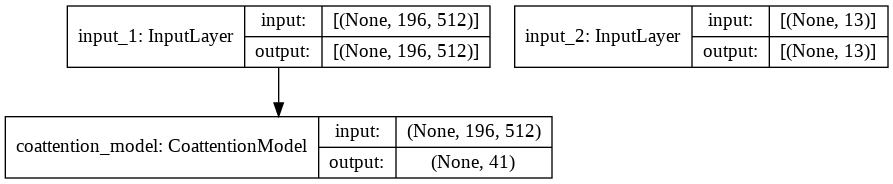

In [47]:
from keras.utils import plot_model
plot_model(model, to_file="parallel_coattention_VGG_emb512_floodnet_vqamodel.png",   show_shapes=True)

In [48]:
model.load_weights(modelsDirectory + ModelName + "/best.hdf5")
model.evaluate(dataset_val)

29/29 [==============================] - 1s 44ms/step - loss: 0.8567 - categorical_accuracy: 0.7007 - mae: 0.0154 - accuracy: 0.7007


[0.8566731214523315,
 0.7006651759147644,
 0.015377623960375786,
 0.7006651759147644]

In [49]:
%reload_ext tensorboard
%tensorboard --logdir CoAttention/logs/fit/Parallel_Coattention_Model

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
sh: 0: getcwd() failed: No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/tensorboard", line 5, in <module>
    from tensorboard.main import run_main
  File "/usr/local/lib/python3.7/dist-packages/tensorboard/main.py", line 43, in <module>
    from tensorboard import default
  File "/usr/local/lib/python3.7/dist-packages/tensorboard/default.py", line 36, in <module>
    from tensorboard.plugins.audio import audio_plugin
  File "/usr/local/lib/python3.7/dist-packages/tensorboard/plugins/audio/audio_plugin.py", line 25, in <module>
    from tensorboard import plugin_util
  File "/usr/local/lib/python3.7/dist-packages/tensorboard/plugin_util.py", line 27, in <module>
    import markdown
  File "/usr/local/lib/python3.7/dist-packages/markdown/__init__.py", line 29, in <m

<h2> Testing </h2>

In [50]:
model.load_weights(modelsDirectory + ModelName + "/best.hdf5")
model.evaluate(dataset_test)

57/57 [==============================] - 3s 45ms/step - loss: 0.7116 - categorical_accuracy: 0.7708 - mae: 0.0130 - accuracy: 0.7708


[0.711638331413269,
 0.7707641124725342,
 0.013037201948463917,
 0.7707641124725342]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 196, 512)]   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 13)]         0                                            
__________________________________________________________________________________________________
coattention_model (CoattentionM (None, 41)           6617643     input_1[0][0]                    
                                                                 input_2[0][0]                    
Total params: 6,617,643
Trainable params: 6,617,643
Non-trainable params: 0
__________________________________________________________________________________________________
None


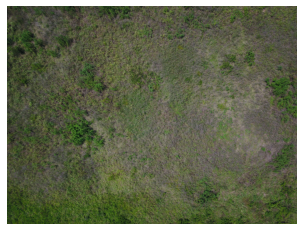

Question : what is the overall condition of the given image?
Actual Answer:  non flooded
Top Predicted answers:  [('non flooded', 99.925476), ('flooded', 0.06995208), ('flooded,non flooded', 0.0024982009), ('1', 0.00076082634), ('2', 0.00061414845)]
******************************************************************************************************************************************************


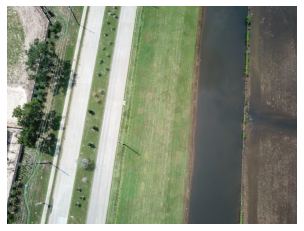

Question : what is the condition of road?
Actual Answer:  non flooded
Top Predicted answers:  [('non flooded', 99.89973), ('flooded', 0.0904831), ('flooded,non flooded', 0.00556206), ('2', 0.0017628605), ('No', 0.00074605073)]
******************************************************************************************************************************************************


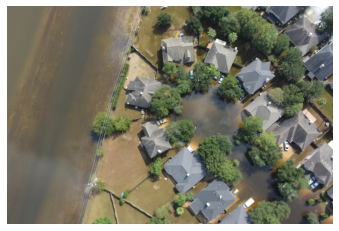

Question : how many buildings are in the image?
Actual Answer:  16
Top Predicted answers:  [('7', 10.115908), ('13', 8.853648), ('4', 8.075264), ('16', 6.868581), ('23', 6.1892276)]
******************************************************************************************************************************************************


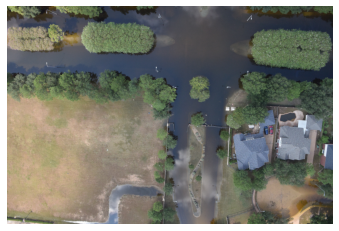

Question : is the entire road non flooded?
Actual Answer:  Yes
Top Predicted answers:  [('Yes', 98.16781), ('No', 1.7608776), ('2', 0.016733084), ('3', 0.011396213), ('8', 0.00597608)]
******************************************************************************************************************************************************


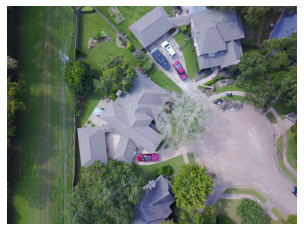

Question : what is the overall condition of the given image?
Actual Answer:  non flooded
Top Predicted answers:  [('non flooded', 97.61568), ('flooded', 2.350386), ('flooded,non flooded', 0.026977185), ('2', 0.0017591905), ('3', 0.0011570174)]
******************************************************************************************************************************************************


In [51]:
tf.keras.backend.clear_session()
model = Build_CoattentionModel()
model.load_weights(modelsDirectory + ModelName + "/best.hdf5")
test_idx = np.random.randint(len(X_test), size = 5)
model_vgg = VGG_Top()
k = 5 #top k answers printed

for idx in test_idx:
    test_image_id = X_test['Image_ID'].values[idx]
    test_question = X_test['Question'].values[idx]
    actual_answer = X_test['Ground_Truth'].values[idx]
    test_image_path = imageDirectory + 'Train_Image/' + test_image_id

    test_image_features = model_vgg(tf.expand_dims(load_image(test_image_path)[0], 0))
    test_image_features = np.reshape(test_image_features,(1, -1,test_image_features.shape[-1]))    
    
    test_question_features = tf.keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences([test_question]),padding='post',
                                                                           maxlen=question_vector_train.shape[1])
    y_pred = model.predict([test_image_features,test_question_features])

    class_indices = tf.math.top_k(y_pred,k=k).indices.numpy()
    percentages = tf.math.top_k(y_pred,k=k).values.numpy()[0] * 100
    predictions = []
    for idx,i in enumerate(class_indices[0]):
        classes = np.zeros((1,41))
        classes[0][i] = 1
        predictions.append((label_encoder.inverse_transform(classes)[0],percentages[idx]))

    img=mpimg.imread(test_image_path)
    imgplot = plt.imshow(img)
    plt.axis('off')
    plt.show()

    print("Question :", test_question.replace("<start> ","").replace(" <end>",""))
    print("Actual Answer: ", actual_answer)
    print("Top Predicted answers: ",predictions)
    print("*"*150)